<a href="https://colab.research.google.com/github/MHiroo/dataset/blob/main/Training_for_Corals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0_ Configurer les chemins

In [ ]:
import numpy as np
import os
import PIL #python imaging library: offre un accés rapide aux données contenues dans une image
import PIL.Image
import tensorflow as tf



In [ ]:

print(tf.__version__)

2.8.0


In [ ]:
import pathlib
dataset_url = "https://github.com/MHiroo/dataset/raw/main/Corals_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='Corals_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

7487488/7476224 [==============================] - 0s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1024


In [ ]:
batch_size = 32 # nombre d'échantillons d'apprentissage à traiter avant la mise à jour des paramètres internes du modèle
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,# Fraction des données d'apprentissage à utiliser comme données de validation.
  subset="training",
  seed=123,#graine aléatoire globale
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1024 files belonging to 2 classes.
Using 820 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1024 files belonging to 2 classes.
Using 204 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['alive', 'dead']


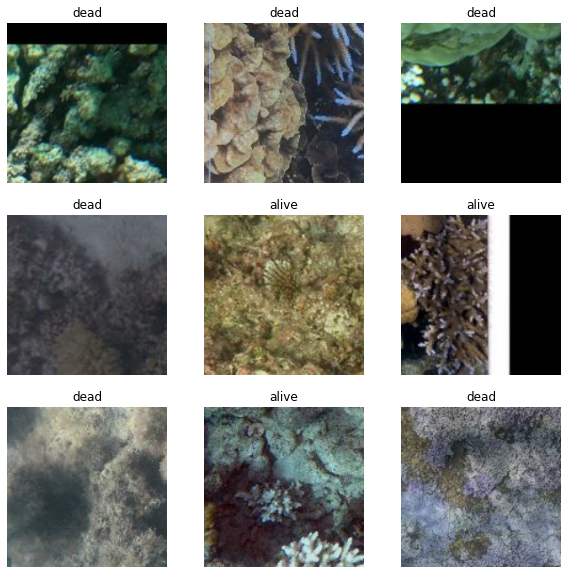

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configurer l'ensemble de données pour les performances


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#Dataset.cache conserve les images en mémoire après leur chargement hors disque au cours  de la première époque
#Dataset.prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation.
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardiser les données

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)#normaliser les valeurs pour qu'elles soient dans la plage [0, 1]

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))# map: utilisé pour modifier à la fois les valeurs et la structure des éléments d'un jeu de données
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.040167887 1.0


Créer le modèle




In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
epochs= 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs #le nombre de passages complets dans l'ensemble de données d'apprentissage.
)

Epoch 1/20
26/26 [==============================] - 31s 1s/step - loss: 0.6547 - accuracy: 0.7024 - val_loss: 0.5813 - val_accuracy: 0.7549
Epoch 2/20
26/26 [==============================] - 27s 1s/step - loss: 0.5728 - accuracy: 0.7622 - val_loss: 0.5606 - val_accuracy: 0.7549
Epoch 3/20
26/26 [==============================] - 27s 1s/step - loss: 0.5564 - accuracy: 0.7622 - val_loss: 0.5592 - val_accuracy: 0.7549
Epoch 4/20
26/26 [==============================] - 26s 1s/step - loss: 0.5295 - accuracy: 0.7622 - val_loss: 0.5289 - val_accuracy: 0.7549
Epoch 5/20
26/26 [==============================] - 27s 1s/step - loss: 0.5067 - accuracy: 0.7695 - val_loss: 0.5490 - val_accuracy: 0.7598
Epoch 6/20
26/26 [==============================] - 27s 1s/step - loss: 0.5020 - accuracy: 0.7683 - val_loss: 0.5440 - val_accuracy: 0.7500
Epoch 7/20
26/26 [==============================] - 26s 1s/step - loss: 0.4664 - accuracy: 0.7598 - val_loss: 0.5458 - val_accuracy: 0.7745
Epoch 8/20
26/26 [==

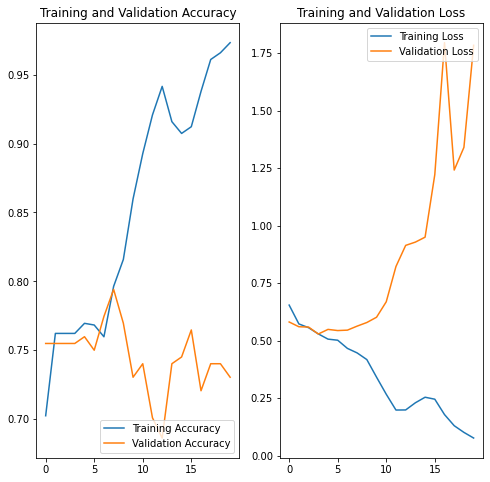

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
alive_url = "https://github.com/MHiroo/dataset/blob/main/deads241.jpg"
alive_path = tf.keras.utils.get_file('Acropora_millepora_Maldives', origin=alive_url)

img = tf.keras.utils.load_img(
    alive_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dead with a 95.84 percent confidence.


In [ ]:
dead_url = "https://github.com/MHiroo/dataset/blob/main/Acropora001.jpg"
dead_path = tf.keras.utils.get_file('dead', origin=dead_url)

img = tf.keras.utils.load_img(
    dead_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to alive with a 60.52 percent confidence.
